In [82]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import KMeans

In [ ]:
from constants import *
from flows.specific.custom_flow import  CustomFlow
from data_sources.specific.coca import Coca
from data_sources.specific.gold_stock_price import GoldStockPrice
from data_sources.specific.malaria_cases import Malaria
from embedders.specific.identity_embedder import IdentityEmbbeder
from embedders.specific.aggregation_embedder import AggregationEmbedder
from embedders.specific.linear_regression_coefficient_embedder import LinearRegressionCoefficientEmbedder

from clusterers.specific.identity_clusterer import IdentityClusterer
from clusterers.specific.sklearn_vector_clusterer import SklearnVectorClusterer
from clusterers.specific.quantile_clusterer import QuantileClusterer

from geography.specific.colombian_municipalities import ColombianMunicipalities

## Kulldorff scan statistic

In [235]:
malaria_data = "/Users/andreaparra/Dropbox/4_Work/DataLamaCovid/projects/mining_malaria/malaria_mining/data/pipeline_data/raw/malaria_cases/anonymized_individual_data.csv"
muni_data = "/Users/andreaparra/Dropbox/4_Work/DataLamaCovid/projects/mining_malaria/malaria_mining/data/pipeline_data/raw/supplementary/muni_id/muni_id.shp"
grid = "/Users/andreaparra/Dropbox/4_Work/DataLamaCovid/data/shape_files/colombia/grid_025degrees/grid_025degrees.shp"
population_data = "/Users/andreaparra/Dropbox/4_Work/DataLamaCovid/projects/mining_malaria/malaria_mining/data/raw/guainia/poblacion_guainia/poblacion_guainia.shp"

# simplified malaria cases
df_malaria_original = pd.read_csv(malaria_data, parse_dates=["date"])
df_malaria_original.dropna(subset=["muni_id"], inplace=True)
df_malaria_original["muni_id"] = df_malaria_original["muni_id"].astype("int").astype("str")
df_malaria_original = df_malaria_original[["muni_id", "num_cases", "date"]].copy()
df_malaria_original["month"] = df_malaria_original.apply(lambda x: x.date.month, axis=1)
df_malaria_original["year"] = df_malaria_original.apply(lambda x: x.date.year, axis=1)


df_malaria_yearly = df_malaria_original.groupby(["muni_id", "year"])["num_cases"].sum().reset_index()
df_malaria_monthly = df_malaria_original.groupby(["muni_id", "year", "month"])["num_cases"].sum().reset_index()

# Geopandas of population
gdf_pop = gpd.read_file(population_data)
gdf_mazanas = gdf_pop[["CODIGO_MZN", "geometry"]].copy()

# Geopandas of municipalities
gdf = gpd.read_file(muni_data)

# grid
gdf_grid = gpd.read_file(grid).drop(columns=["left", "top", "right", "bottom"])


In [236]:
gdf_malaria_yearly = gdf.merge(df_malaria_yearly, on="muni_id")
gdf_malaria_monthly = gdf.merge(df_malaria_monthly, on="muni_id")
gdf_malaria_yearly.head()

,muni_id,geometry,year,num_cases
0,18001,"POLYGON ((-75.42074 2.19413, -75.42042 2.19412...",2006,1
1,18001,"POLYGON ((-75.42074 2.19413, -75.42042 2.19412...",2007,13
2,18001,"POLYGON ((-75.42074 2.19413, -75.42042 2.19412...",2008,12
3,18001,"POLYGON ((-75.42074 2.19413, -75.42042 2.19412...",2009,27
4,18001,"POLYGON ((-75.42074 2.19413, -75.42042 2.19412...",2010,20


In [237]:
# use only guainia
guainia_codigos = ['94001', '94343', '94663', '94883', '94884',
       '94885', '94886', '94887', '94888']
gdf_guainia = gdf_malaria_yearly[gdf_malaria_yearly["muni_id"].isin(guainia_codigos)].copy()
gdf_guainia_2018 = gdf_guainia[gdf_guainia["year"] == 2018][["muni_id", "geometry", "year", "num_cases"]].copy()

gdf_guainia_2018["centroid"] = gdf_guainia_2018.apply(lambda row: row.geometry.centroid, axis=1)
gdf_guainia_2018["lon"] = gdf_guainia_2018.apply(lambda row: row.centroid.x, axis=1)
gdf_guainia_2018["lat"] = gdf_guainia_2018.apply(lambda row: row.centroid.y, axis=1)

gdf_guainia_2018.set_index("muni_id", inplace=True)
gdf_guainia_2018.head()

/Users/andreaparra/Virtual-Envs/malaria_pl/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,geometry,year,num_cases,centroid,lon,lat
muni_id,,,,,,
94001,"POLYGON ((-67.67638 3.91228, -67.67305 3.90931...",2018,3103,POINT (-68.45723659176863 3.3194049847811664),-68.457237,3.319405
94343,"POLYGON ((-68.91332 3.68216, -68.91308 3.68216...",2018,27,POINT (-69.39877038331507 3.31350791665195),-69.398770,3.313508
94663,"POLYGON ((-70.10453 3.38436, -70.10219 3.38436...",2018,10,POINT (-70.2693256358718 2.808882222497798),-70.269326,2.808882
94883,"POLYGON ((-67.34976 2.50451, -67.34942 2.50438...",2018,31,POINT (-67.33988543129911 2.1559086403825805),-67.339885,2.155909
94884,"POLYGON ((-67.53850 3.17757, -67.53825 3.17750...",2018,11,POINT (-68.20898715184828 2.5075798361979653),-68.208987,2.507580


In [238]:
# spread cases across polygon according to centroid and specific distribution
def generate_points(centroid, num_points, dist_lat=None, dist_lon=None):

    # if no distributions are given, use normal around latitude and longitude fo centroid
    if not dist_lon:
        dist_lon = np.random.normal(centroid.x, 0.2, size=num_points)

    if not dist_lat:
        dist_lat = np.random.normal(centroid.y, 0.2, size=num_points)

    return [(lon, lat) for lon, lat in zip(dist_lon, dist_lat)]


<AxesSubplot:>

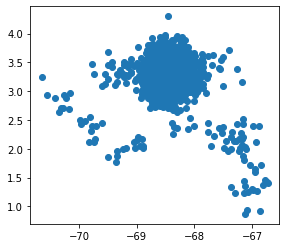

In [239]:
# Generate distribution of cases for each municipality
gdf_random = gpd.GeoDataFrame(columns=["muni_id", "geometry"])
for muni_id in gdf_guainia_2018.reset_index()["muni_id"].unique():
    random_points = generate_points(gdf_guainia_2018.at[muni_id, "centroid"], gdf_guainia_2018.at[muni_id, "num_cases"])
    random_points = [Point(point) for point in random_points]

    gdf_random_tmp = gpd.GeoDataFrame({"muni_id": muni_id, "geometry":random_points})
    gdf_random = gpd.GeoDataFrame(pd.concat([gdf_random, gdf_random_tmp], ignore_index=True))

gdf_random = gdf_random.set_crs("EPSG:4326")
gdf_random.plot()


In [240]:
# Overlay grid onto guainia map to get all squares
gdf_grid_guainia = gpd.overlay(gdf[gdf["muni_id"].isin(guainia_codigos)], gdf_grid, how='intersection')
grid_members = gdf_grid_guainia.id.unique()
gdf_grid_guainia.head()

,muni_id,id,geometry
0,94001,3521.0,"POLYGON ((-69.40194 2.89501, -69.40186 2.89508..."
1,94343,3521.0,"POLYGON ((-69.23568 3.12507, -69.23596 3.12516..."
2,94001,3522.0,"POLYGON ((-69.30329 2.64481, -69.30336 2.64498..."
3,94343,3522.0,"POLYGON ((-69.40218 2.89473, -69.40227 2.89462..."
4,94888,3522.0,"POLYGON ((-69.46479 2.88951, -69.46451 2.88935..."


In [241]:
# Overlay grid onto random cases to get case count per new grid
gdf_overlayed = gpd.overlay(gdf_random, gdf_grid, how='intersection')
gdf_overlayed["num_cases"] = 1

df_overlayed = gdf_overlayed.groupby(["id"])["num_cases"].sum().reset_index()
gdf_overlayed = gdf_grid.merge(df_overlayed, on="id")

# Add grid squares with no cases
to_add = list(set(grid_members) - set(gdf_overlayed.id.unique()))
gdf_tmp = gdf_grid[gdf_grid["id"].isin(to_add)].copy()
gdf_tmp["num_cases"] = 0
gdf_overlayed = pd.concat([gdf_overlayed, gdf_tmp])

gdf_overlayed.tail()

,id,geometry,num_cases
4014,4015.0,"POLYGON ((-67.73562 3.89473, -67.48562 3.89473...",0
4018,4019.0,"POLYGON ((-67.73562 2.89473, -67.48562 2.89473...",0
4019,4020.0,"POLYGON ((-67.73562 2.64473, -67.48562 2.64473...",0
4086,4087.0,"POLYGON ((-67.48562 3.64473, -67.23562 3.64473...",0
4089,4090.0,"POLYGON ((-67.48562 2.89473, -67.23562 2.89473...",0


In [242]:
gdf_pop_overlayed = gpd.overlay(gdf_pop, gdf_grid, how='intersection')
df_pop_overlayed = gdf_pop_overlayed.groupby("id")["num_person"].sum().reset_index()
gdf_pop_overlayed = gdf_grid.merge(df_pop_overlayed, on="id")

# Add grid squares with no cases
to_add = list(set(grid_members) - set(gdf_pop_overlayed.id.unique()))
gdf_tmp = gdf_grid[gdf_grid["id"].isin(to_add)].copy()
gdf_tmp["num_person"] = 0
gdf_pop_overlayed = pd.concat([gdf_pop_overlayed, gdf_tmp])

gdf_pop_overlayed.head()


,id,geometry,num_person
0,3377.0,"POLYGON ((-69.98562 3.64473, -69.73562 3.64473...",912
1,3382.0,"POLYGON ((-69.98562 2.39473, -69.73562 2.39473...",152
2,3597.0,"POLYGON ((-69.23562 1.89473, -68.98562 1.89473...",217
3,3803.0,"POLYGON ((-68.48562 3.64473, -68.23562 3.64473...",108
4,3873.0,"POLYGON ((-68.23562 3.89473, -67.98562 3.89473...",198


In [243]:
gdf_overlayed_all = gdf_pop_overlayed[["id", "num_person"]].merge(gdf_overlayed, on="id", how="outer")
gdf_overlayed_all["centroid"] = gdf_overlayed_all.apply(lambda row: row.geometry.centroid, axis=1)

num_person_max = gdf_overlayed_all["num_person"].max()
num_person_min = gdf_overlayed_all["num_person"].min()
num_cases_max = gdf_overlayed_all["num_cases"].max()
num_cases_min = gdf_overlayed_all["num_cases"].min()
gdf_overlayed_all["num_person_norm"] = (gdf_overlayed_all["num_person"] - num_person_min) / (num_person_max-num_person_min)
gdf_overlayed_all["num_cases_norm"] = (gdf_overlayed_all["num_cases"] - num_cases_min) / (num_cases_max-num_cases_min)

gdf_overlayed_all.head()

/Users/andreaparra/Virtual-Envs/malaria_pl/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,id,num_person,geometry,num_cases,centroid,num_person_norm,num_cases_norm
0,3377.0,912.0,"POLYGON ((-69.98562 3.64473, -69.73562 3.64473...",1,POINT (-69.860620556 3.5197277620000005),0.047806,0.001637
1,3382.0,152.0,"POLYGON ((-69.98562 2.39473, -69.73562 2.39473...",1,POINT (-69.860620556 2.2697277620000005),0.007968,0.001637
2,3597.0,217.0,"POLYGON ((-69.23562 1.89473, -68.98562 1.89473...",0,POINT (-69.110620556 1.7697277620000005),0.011375,0.000000
3,3803.0,108.0,"POLYGON ((-68.48562 3.64473, -68.23562 3.64473...",390,POINT (-68.360620556 3.5197277620000005),0.005661,0.638298
4,3873.0,198.0,"POLYGON ((-68.23562 3.89473, -67.98562 3.89473...",22,POINT (-68.110620556 3.7697277620000005),0.010379,0.036007


In [244]:
# Calculate Bernouilli likelihood ratio
def bernoulli_LR(C, c, N, n):
    '''
    C: total number of cases
    c: number of cases in window
    N: Total population
    n: population in window
    '''
    N_n = N - n
    C_c = C - c

    _1 = (C/n)**c
    _2 = ((n-c) / n)**(n-c)
    _3 = (C_c / N_n)**C_c
    _4 = ((N_n - C_c) / N_n)**(N_n - C_c)

    return _1 * _2 * _3 * _4


In [252]:
# Run procedure

window_thr = 0.15  # as percent of total population

N = gdf_overlayed_all.num_person.sum()
C = gdf_overlayed_all.num_cases.sum()

stopping_criteria = window_thr*N

windows = []
window_scores = []

for i in gdf_overlayed_all.id.unique():
    population_count = gdf_overlayed_all.set_index("id").at[i, "num_person"]

    # check if stopping criteria is met
    if population_count >= stopping_criteria:
        # calculate LR
        c = gdf_overlayed_all.set_index("id").at[i, "num_cases"]
        n = population_count

        # print(f"n: {n}")
        # print(f"c: {c}")        

        lr = bernoulli_LR(C, c, N, n)
        window = [i]
        windows.append(window)
        window_scores.append(lr)
    
    # find window members
    else:
        gdf_overlayed_all["intersects"] = False
        step = 0
        while population_count <= stopping_criteria:
            # make a circle around centroid of radius 0.25 degrees (grid is of 0.25 degrees)
            # and increase until stopping criteria is met
            group = gdf_overlayed_all.set_index("id").at[i, "centroid"].buffer(0.25 + step)
            gdf_overlayed_all["intersects"] = gdf_overlayed_all.apply(lambda x: x.geometry.intersects(group), axis=1)

            population_count += gdf_overlayed_all[gdf_overlayed_all["intersects"]]["num_person"].sum()
            step += 0.25

        # calculate LR
        c = gdf_overlayed_all[gdf_overlayed_all["intersects"]]["num_cases"].sum()
        n = population_count

        # print(f"n: {n}")
        # print(f"c: {c}")     

        lr = bernoulli_LR(C, c, N, n)
        window = gdf_overlayed_all[gdf_overlayed_all["intersects"]]["id"].values
        windows.append(window)
        window_scores.append(lr)        



/var/folders/_r/xw7p8d357pbgnk76nh3khwkc0000gn/T/ipykernel_94084/2771207962.py:15: RuntimeWarning: overflow encountered in double_scalars
  _4 = ((N_n - C_c) / N_n)**(N_n - C_c)
/var/folders/_r/xw7p8d357pbgnk76nh3khwkc0000gn/T/ipykernel_94084/2771207962.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return _1 * _2 * _3 * _4
/var/folders/_r/xw7p8d357pbgnk76nh3khwkc0000gn/T/ipykernel_94084/2771207962.py:14: RuntimeWarning: overflow encountered in double_scalars
  _3 = (C_c / N_n)**C_c
/var/folders/_r/xw7p8d357pbgnk76nh3khwkc0000gn/T/ipykernel_94084/2771207962.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return _1 * _2 * _3 * _4
/var/folders/_r/xw7p8d357pbgnk76nh3khwkc0000gn/T/ipykernel_94084/2771207962.py:14: RuntimeWarning: overflow encountered in double_scalars
  _3 = (C_c / N_n)**C_c
/var/folders/_r/xw7p8d357pbgnk76nh3khwkc0000gn/T/ipykernel_94084/2771207962.py:14: RuntimeWarning: overflow encountered in double_scalars
  _3 = (C_c / N_n)**

In [253]:
windows_str = ["|".join(str(int(_w)) for _w in w) for w in windows]
df_lr = pd.DataFrame({"scores": window_scores, "windows": windows_str})
df_lr = df_lr.replace([np.inf, -np.inf], np.nan)

members = df_lr.iloc[df_lr["scores"].idxmax()]["windows"]
members = [float(s) for s in members.split("|")]
gdf_members = gdf_grid_guainia[gdf_grid_guainia["id"].isin(members)].copy()
gdf_members.head()

,scores,windows
0,0.0,3377|3236|3237|3238|3306|3307|3308|3309|3378|3...
1,0.0,3377|3382|3597|3096|3097|3167|3168|3169|3236|3...
2,0.0,3377|3382|3597|3803|3097|3167|3168|3169|3237|3...
3,0.0,3803|3873|3944|3660|3661|3662|3731|3732|3733|3...
4,NaN,3803|3873|3943|3944|3801|3802|3872|3874|3945


<AxesSubplot:>

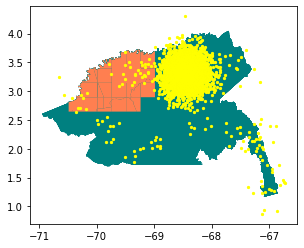

In [262]:
ax = gdf_guainia.plot(color="teal")
gdf_members.plot(ax=ax, color="coral")
gdf_random.plot(ax=ax, color="yellow", markersize=5)
